In [31]:
import pandas as pd
import numpy as np

## pre-processing the data:
from sklearn.preprocessing import MinMaxScaler

## NN tools we need:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

##in order to perform the visualization tasks:
import matplotlib.pyplot  as plt

## sklearn lineal regression:
from sklearn.linear_model import LinearRegression

##grid search cv
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

## error metrics:
from sklearn.metrics import mean_squared_error

In [2]:
## more readable format to the numbers than scientific notation:
np.set_printoptions(suppress=True)

In [132]:
## we import our training data:
xTrain = pd.read_pickle("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/processed/xTrain_f2.pkl")
yTrain = pd.read_pickle("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/processed/yTrain_f2.pkl")

## we import our test data:
yTest = pd.read_pickle("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/processed/yTest_f2.pkl")
xTest = pd.read_pickle("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/processed/xTest_f2.pkl")

In [8]:
#unlinke in our lastest dataset now we use the last week as feature (only that):
xTrain

,seasonability_circ_cos,seasonability_circ_sin,time,y_t-1
1,0.965926,2.588190e-01,2015.020833,2.258586e+08
2,0.923880,3.826834e-01,2015.041667,6.928355e+07
3,0.866025,5.000000e-01,2015.062500,1.181928e+08
4,0.793353,6.087614e-01,2015.083333,2.957297e+07
5,0.707107,7.071068e-01,2015.104167,4.668751e+07
...,...,...,...,...
187,0.866025,-5.000000e-01,2018.895833,1.147054e+07
188,0.923880,-3.826834e-01,2018.916667,4.592902e+06
189,0.965926,-2.588190e-01,2018.937500,9.887271e+07
190,0.991445,-1.305262e-01,2018.958333,3.536235e+06


In [5]:
##we should drop the NaNs (first observation):
xTrain = xTrain.dropna()

In [12]:
## in order to make them equal in lenght we remove the first observation of the labels as well:
yTrain = yTrain.drop(0)

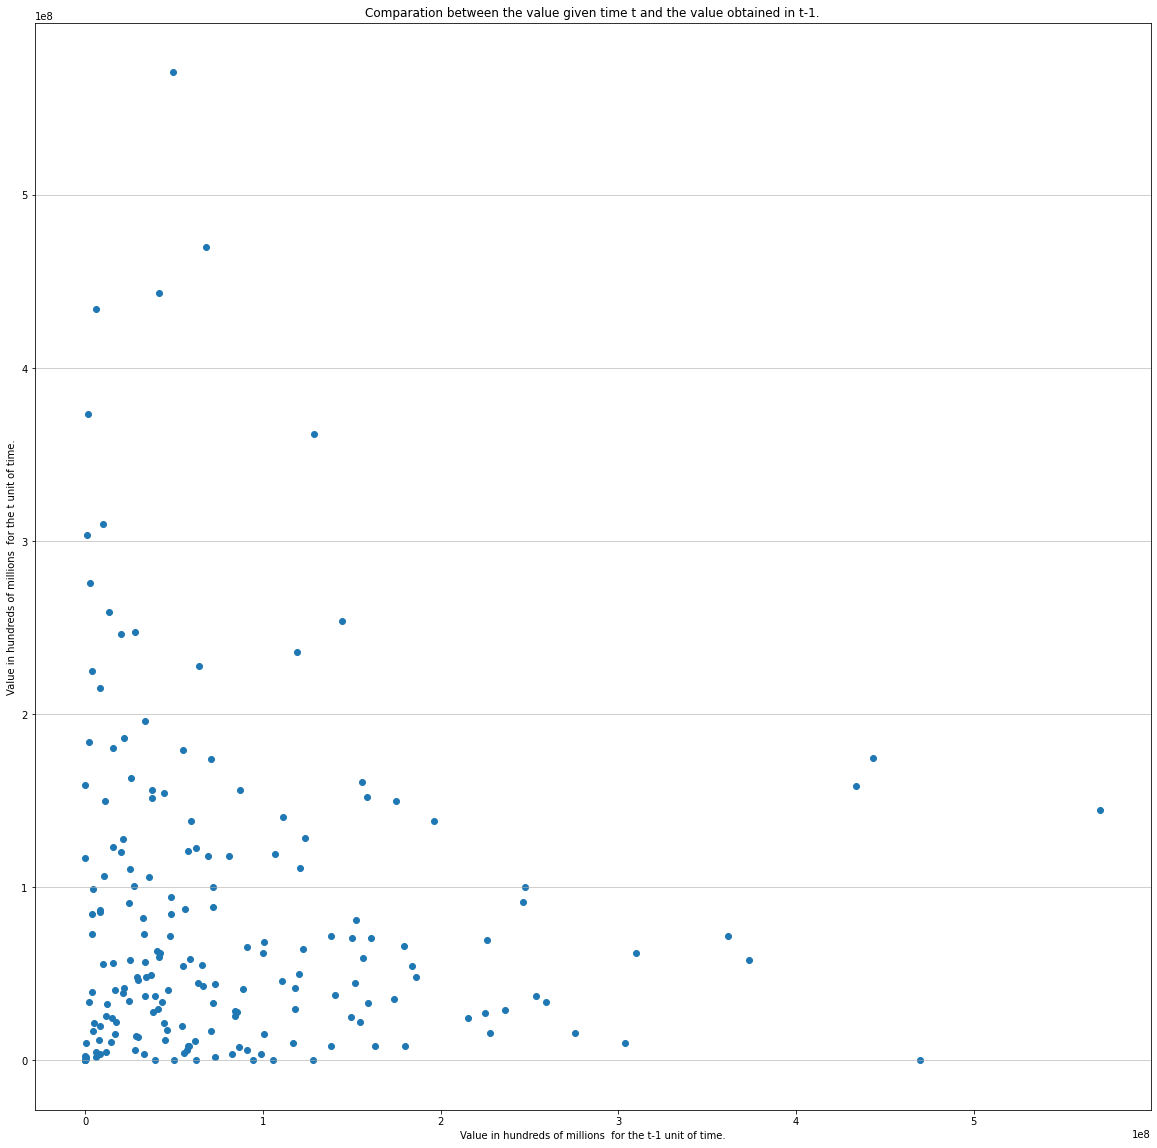

In [30]:
##just to check if there exist any type of lineal relationship we proceed to print an scatter plot:
from pylab import rcParams
ax = plt.figure().add_subplot(111)
ax.scatter(y=yTrain.target,x = xTrain['y_t-1'])
plt.title('Comparation between the value given time t and the value obtained in t-1.')
plt.xlabel('Value in hundreds of millions  for the t-1 unit of time.')
plt.ylabel('Value in hundreds of millions  for the t unit of time.')

plt.grid(axis='y', alpha=0.75)

rcParams['figure.figsize'] = 20, 20

In [104]:
from sklearn import linear_model
from scipy import stats
import numpy as np


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [105]:
x = np.asarray(xTrain['y_t-1'])
x = x.reshape(-1,1)

In [106]:
y = np.asarray(yTrain.target)
y = y.reshape(-1,1)

In [107]:
reg = LinearRegression()

In [108]:
fit_train = reg.fit(x, y= y)

In [109]:
fit_train.p

array([[0.00000001]])

In [113]:
#Preprocessing the data: 
scaler = MinMaxScaler(feature_range=(0,1))

In [114]:
scaled_target = scaler.fit_transform(y)

In [116]:
#we should scale our features as well: 
scaled_target_1 = scaler.fit_transform(x)

In [121]:
scaled_target_1 = scaled_target_1.reshape(191,1,1)

In [123]:
## would be recommendable to proceed with a grid search crossvalidation,
## let's do it with the number of neurons:
def create_model(neurons):
    input_shape = (1,1)

    ## we build the model:
    model = Sequential()

    model.add(LSTM(units = neurons, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units = neurons, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = neurons))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation = 'relu'))
    
    ## we choose adam algorithm:
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    return model

## our seed:
seed = 1
np.random.seed(seed)

## we compile our model and we fit our model for any number of neurons:
model = KerasRegressor(build_fn= create_model,epochs=100)

## reasonable examples of neurons, our cv is 1 because we have few data
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(X=scaled_target_1, y=scaled_target)



# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0471
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0447
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0424
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0384
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0352
Epoch 8/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0337
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0321
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 11/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0302
Epoch 12/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0294
Epoch 13/100
6/6 [==============================] - 0s 6ms/st

In [199]:
input_shape = (1,1)

## we build the model:
model = Sequential()

model.add(LSTM(units = 10, return_sequences = True, input_shape = input_shape))
model.add(LSTM(units = 10, return_sequences = True))
model.add(LSTM(units = 10))
model.add(Dense(units = 1, activation = 'relu'))

In [200]:
## we compile our model and we fit our model:

model.compile(optimizer='adam', loss = 'mean_squared_error')
history = model.fit(x=scaled_target_1,y=scaled_target,epochs=3000)

Epoch 1/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0467
Epoch 2/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0437
Epoch 3/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0408
Epoch 4/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0382
Epoch 5/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 6/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0336
Epoch 7/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0318
Epoch 8/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0303
Epoch 9/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0292
Epoch 10/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0283
Epoch 11/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0278
Epoch 12/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0275
Epoch 13/3000
6/6 [==============================

6/6 [==============================] - 0s 6ms/step - loss: 0.0273
Epoch 104/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0273
Epoch 105/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0273
Epoch 106/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0273
Epoch 107/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0273
Epoch 108/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0272
Epoch 109/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0272
Epoch 110/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0273
Epoch 111/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0272
Epoch 112/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0273
Epoch 113/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0273
Epoch 114/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0272
Epoch 115/3000
6/6 [=======================

6/6 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 205/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 206/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 207/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 208/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 209/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 210/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 211/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 212/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 213/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 214/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 215/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 216/3000
6/6 [=======================

6/6 [==============================] - 0s 11ms/step - loss: 0.0272
Epoch 306/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 307/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 308/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 309/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 310/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0272
Epoch 311/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 312/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 313/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 314/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 315/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 316/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 317/3000
6/6 [======================

6/6 [==============================] - 0s 9ms/step - loss: 0.0271
Epoch 407/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0271
Epoch 408/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0271
Epoch 409/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0271
Epoch 410/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 411/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 412/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0271
Epoch 413/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 414/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 415/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 416/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 417/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 418/3000
6/6 [================

6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 508/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 509/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 510/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 511/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 512/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 513/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 514/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 515/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 516/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 517/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0271
Epoch 518/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0271
Epoch 519/3000
6/6 [=======================

6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 609/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 610/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 611/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 612/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 613/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 614/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 615/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 616/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 617/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 618/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 619/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 620/3000
6/6 [=======================

6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 710/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 711/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 712/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 713/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 714/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 715/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 716/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 717/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 718/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 719/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 720/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 721/3000
6/6 [=======================

Epoch 810/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 811/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 812/3000
6/6 [==============================] - ETA: 0s - loss: 0.010 - 0s 7ms/step - loss: 0.0270
Epoch 813/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 814/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 815/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 816/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 817/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 818/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 819/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 820/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 821/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoc

6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 911/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 912/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 913/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 914/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 915/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 916/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 917/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 918/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0271
Epoch 919/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 920/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 921/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 922/3000
6/6 [=======================

6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1012/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1013/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1014/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1015/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1016/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1017/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1018/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1019/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 1020/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1021/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1022/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1023/3000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1111/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1112/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1113/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 1114/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1115/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1116/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 1117/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1118/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1119/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1120/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1121/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1122/3000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1211/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1212/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1213/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 1214/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1215/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1216/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1217/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1218/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1219/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1220/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1221/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1222/3000
6/6 [===========

6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1310/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1311/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1312/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1313/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 1314/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1315/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1316/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1317/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1318/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1319/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 1320/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1321/3000
6/6 [===========

6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1409/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1410/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1411/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1412/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1413/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1414/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1415/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1416/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1417/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 1418/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1419/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1420/3000
6/6 [===========

6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1509/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 1510/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1511/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 1512/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 1513/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1514/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1515/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1516/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1517/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1518/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 1519/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.0270
Epoch 1520/3000
6/6 [==========

6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1608/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 1609/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1610/3000
6/6 [==============================] - 0s 11ms/step - loss: 0.0270
Epoch 1611/3000
6/6 [==============================] - 0s 11ms/step - loss: 0.0270
Epoch 1612/3000
6/6 [==============================] - 0s 11ms/step - loss: 0.0270
Epoch 1613/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 1614/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1615/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 1616/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1617/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1618/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1619/3000
6/6 [========

6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1708/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1709/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 1710/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1711/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1712/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1713/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1714/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 1715/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.0269
Epoch 1716/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1717/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1718/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1719/3000
6/6 [==========

6/6 [==============================] - 0s 10ms/step - loss: 0.0270
Epoch 1808/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1809/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1810/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 1811/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1812/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1813/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 1814/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1815/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 1816/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 1817/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 1818/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1819/3000
6/6 [==========

Epoch 1907/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1908/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 1909/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 1910/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 1911/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1912/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1913/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 1914/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 1915/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 1916/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 1917/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 1918/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 1919/3000


6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2007/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 2008/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 2009/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0269
Epoch 2010/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 2011/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2012/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2013/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2014/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 2015/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2016/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 2017/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 2018/3000
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2106/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2107/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 2108/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 2109/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2110/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 2111/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2112/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2113/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2114/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2115/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2116/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2117/3000
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2206/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2207/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 2208/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 2209/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2210/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 2211/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0269
Epoch 2212/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 2213/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2214/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2215/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2216/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 2217/3000
6/6 [===========

Epoch 2305/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 2306/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2307/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 2308/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 2309/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2310/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0269
Epoch 2311/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2312/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0269
Epoch 2313/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 2314/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 2315/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2316/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2317/3000


6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 2405/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 2406/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 2407/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 2408/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2409/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0269
Epoch 2410/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 2411/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2412/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 2413/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 2414/3000
6/6 [==============================] - 0s 10ms/step - loss: 0.0269
Epoch 2415/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 2416/3000
6/6 [==========

Epoch 2504/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 2505/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2506/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2507/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2508/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 2509/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2510/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2511/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2512/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2513/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2514/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2515/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 2516/3000


6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2604/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2605/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2606/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 2607/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 2608/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2609/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 2610/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2611/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2612/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2613/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 2614/3000
6/6 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 2615/3000
6/6 [===========

Epoch 2703/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2704/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2705/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2706/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2707/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 2708/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2709/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2710/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2711/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 2712/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2713/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 2714/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 2715/3000


6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2803/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2804/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0269
Epoch 2805/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2806/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 2807/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0269
Epoch 2808/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 2809/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2810/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2811/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 2812/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 2813/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 2814/3000
6/6 [===========

6/6 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 2903/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2904/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 2905/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 2906/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2907/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2908/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2909/3000
6/6 [==============================] - 0s 9ms/step - loss: 0.0269
Epoch 2910/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 2911/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 2912/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 2913/3000
6/6 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 2914/3000
6/6 [===========

In [201]:
x_test = xTest['y_t-1']

In [202]:
x_test = np.asarray(x_test.dropna())

In [203]:
x_test = x_test.reshape(-1,1)

In [204]:
x_test_scaled = scaler.transform(x_test)
x_test_scaled = x_test_scaled.reshape(47,1,1)

In [205]:
y_test = yTest['target']

In [206]:
y_test = np.asanyarray(y_test.drop(0))

In [207]:
y_output = model.predict(x_test_scaled)

In [208]:
y_predicted = scaler.inverse_transform(y_output)

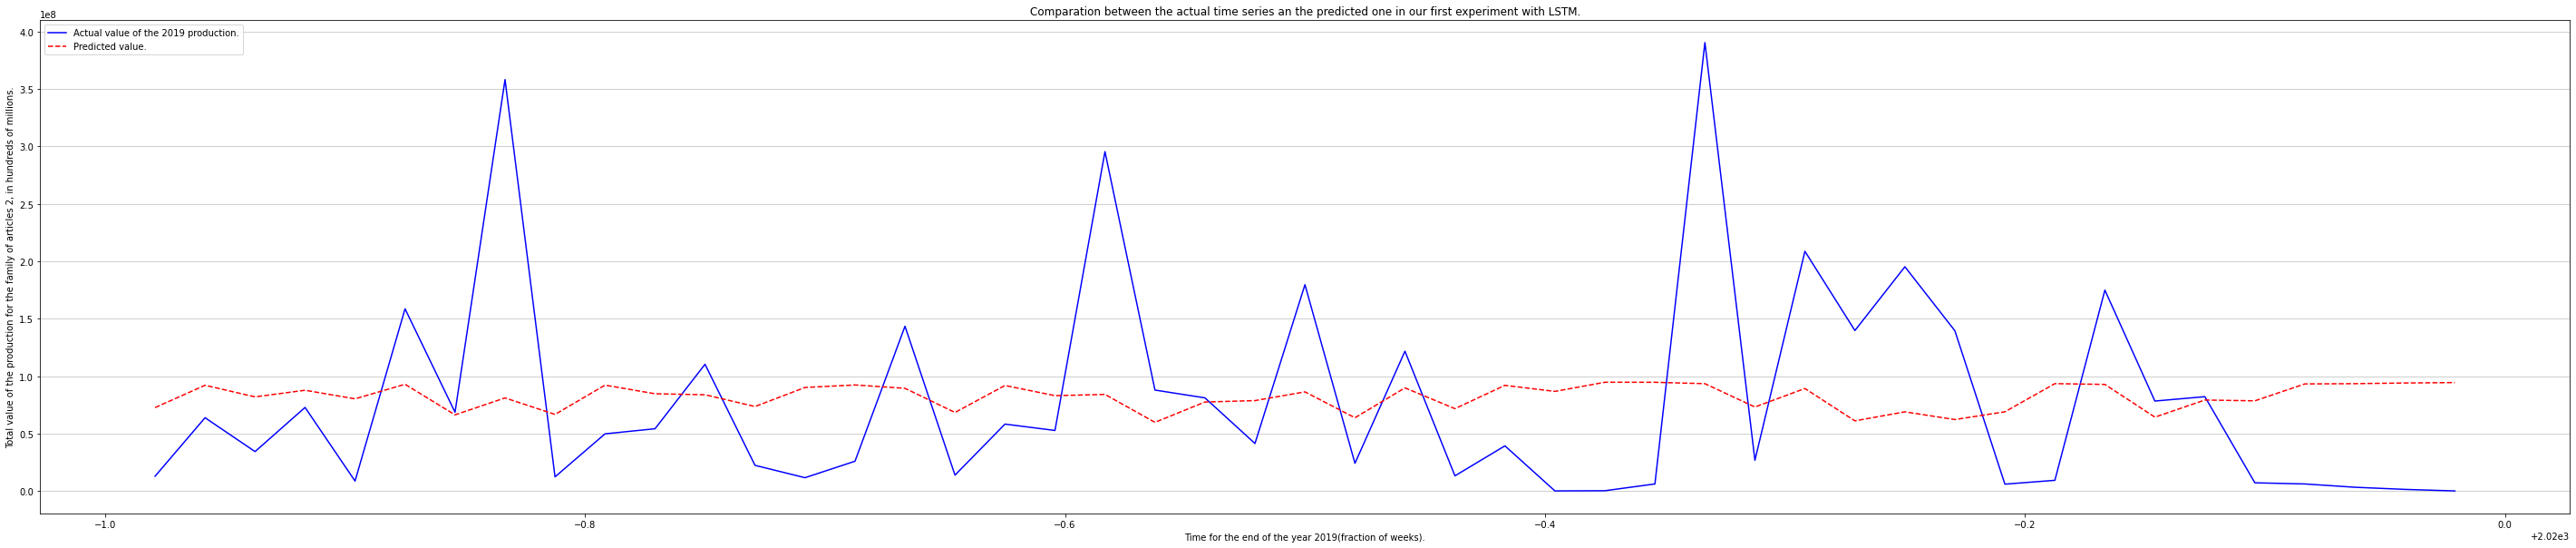

In [210]:
t = xTest.time
t = t.drop(0)
from pylab import rcParams
ax = plt.figure().add_subplot(111)
ax.plot(t,y_test,'-b', label = 'Actual value of the 2019 production.')
ax.plot(t,y_predicted, '--r', label = 'Predicted value.')
ax. legend(loc='upper left')
plt.title('Comparation between the actual time series an the predicted one in our second experiment with LSTM.')
plt.xlabel('Time for the end of the year 2019(fraction of weeks).')
plt.ylabel('Total value of the production for the family of articles 2, in hundreds of millions.')

plt.grid(axis='y', alpha=0.75)

rcParams['figure.figsize'] = 50, 10

In [211]:
## very high error:
mean_squared_error(y_test, y_predicted)

8480781026713648.0